### Using MNIST_TINY to build Regression DataBlock
Tutorial: https://dev.fast.ai/tutorial.datablock

In [1]:
from fastai2.basics import *
from fastai2.vision.all import *

from matplotlib import pyplot as plt

import os, sys
import pandas as pd
from IPython.display import display

### Basic Classification Model

In [2]:
path = untar_data(URLs.MNIST_TINY)
dls  = ImageDataLoaders.from_folder(path, valid_pct=0.2)
learn = cnn_learner(dls, resnet18, pretrained=True,metrics=[accuracy])
learn.fit(1)

epoch,train_loss,valid_loss,accuracy,time
0,0.930658,0.434209,0.873684,00:11


In [3]:
interp = ClassificationInterpretation.from_learner(learn)
interp.confusion_matrix()

array([[123,  13,  10],
       [  5, 126,   3],
       [  3,   2,   0]])

In [4]:
dls.vocab

(#3) ['3','7','test']

### Build Classification from pandas

In [5]:
df = pd.DataFrame({'fn':[],'y':[]})

for digit_cat in os.listdir(path/'train'):
    
    tmp = [f'/train/{digit_cat}/{e}' for e in 
           os.listdir(path/'train'/str(digit_cat))] 
    df_tmp = pd.DataFrame({'fn': tmp})
    df_tmp['y'] = digit_cat
    df = pd.concat((df, df_tmp))

In [6]:
display(df.head(2))
display(df.tail(2))
df.dtypes

,fn,y
0,/train/3/7.png,3
1,/train/3/7030.png,3


,fn,y
361,/train/7/9992.png,7
362,/train/7/9999.png,7


fn    object
y     object
dtype: object

In [7]:
mnist2 = DataBlock(blocks=(ImageBlock(cls=PILImageBW), CategoryBlock), 
                  splitter=RandomSplitter(),
                   get_x=ColReader('fn', pref=path),
                   get_y=ColReader('y'),
                  )

In [8]:
mnist2_dls = mnist2.dataloaders(df)
mnist2_dls.vocab

(#2) ['3','7']

In [9]:
mnist2_dls.one_batch()[1][:5]

tensor([0, 1, 1, 0, 1])

In [10]:
learn2 = cnn_learner(mnist2_dls, resnet18, pretrained=True,metrics=[accuracy])
learn2.fit(1)

epoch,train_loss,valid_loss,accuracy,time
0,0.763503,0.273382,0.893617,00:05


### Build a Regression Learner from pandas

In [11]:
df2 = df.copy()
df2['y'] = df2['y'].astype('float')

In [12]:
mnist3 = DataBlock(blocks=(ImageBlock(cls=PILImageBW), RegressionBlock()), 
                  splitter=RandomSplitter(),
                   get_x=ColReader('fn', pref=path),
                   get_y=ColReader('y'),
                  )

In [13]:
mnist3_dls = mnist3.dataloaders(df2)

In [14]:
b = mnist3_dls.one_batch()
b[1][:5]

tensor([3., 3., 7., 3., 3.])

In [15]:
try: mnist3_dls.vocab
except: print('no vocab attr')

no vocab attr


In [16]:
learn3 = cnn_learner(mnist3_dls, resnet18, pretrained=True,metrics=[mse])

In [17]:
learn2.loss_func, learn3.loss_func

(FlattenedLoss of CrossEntropyLoss(), FlattenedLoss of MSELoss())

In [18]:
learn3.fit(1)

epoch,train_loss,valid_loss,mse,time
0,30.813972,30.788099,30.788099,00:06


##### Compare Regression Perf
Worse than baseline

In [19]:
y = []
for b in mnist3_dls.valid:
    y += b[1]

mean = tensor(y).mean()    

yhat = [mean for _ in range(len(y))]

baseline_mse = mse(tensor(yhat), tensor(y))

baseline_mse

tensor(3.9419)

In [20]:
preds = learn3.get_preds()
model_mse = mse(preds[0], preds[1])
model_mse

tensor(30.7881)

##### Clearly something is wrong with this model, as seen by yhat hist
Needs to be normalized?

Text(0.5, 1.0, 'yhat values for validation: values in {3.,7.}')

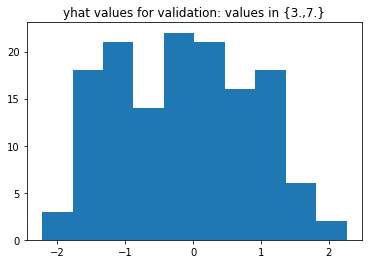

In [21]:
pred_values = [e[0] for e in preds[0].tolist()]
plt.hist(pred_values);
plt.title('yhat values for validation: values in {3.,7.}')

Text(0.5, 1.0, 'yactual values for validation: values in {3.,7.}')

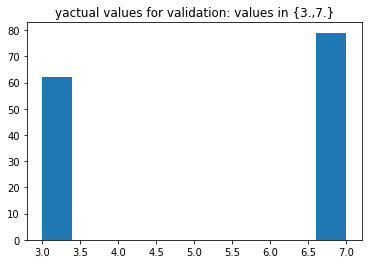

In [22]:
pred_values = [e for e in preds[1].tolist()]
plt.hist(pred_values);
plt.title('yactual values for validation: values in {3.,7.}')

### Build a simple Point Learner
It really struggles here to fit y = (0,0) for all observations.

In [23]:
def dummy_point(o):
    return tensor(0., 0.)

In [284]:
xxx = DataBlock(blocks=(ImageBlock(cls=PILImageBW), RegressionBlock(2)), 
                  splitter=RandomSplitter(),
                   get_x=ColReader('fn', pref=path),
                   get_y=dummy_point,
                  )
xxx_dls = xxx.dataloaders(df)

In [285]:
xxx_dls.one_batch()[0].shape

torch.Size([64, 1, 28, 28])

In [286]:
mnist4_dls.one_batch()[0].shape

torch.Size([64, 3, 28, 28])

In [290]:
PILImageBW

fastai2.vision.core.PILImageBW

In [289]:
xxx_dls.dataset

(#568) [(PILImageBW mode=L size=28x28, tensor([0., 0.])),(PILImageBW mode=L size=28x28, tensor([0., 0.])),(PILImageBW mode=L size=28x28, tensor([0., 0.])),(PILImageBW mode=L size=28x28, tensor([0., 0.])),(PILImageBW mode=L size=28x28, tensor([0., 0.])),(PILImageBW mode=L size=28x28, tensor([0., 0.])),(PILImageBW mode=L size=28x28, tensor([0., 0.])),(PILImageBW mode=L size=28x28, tensor([0., 0.])),(PILImageBW mode=L size=28x28, tensor([0., 0.])),(PILImageBW mode=L size=28x28, tensor([0., 0.]))...]

In [288]:
mnist4_dls.dataset

(#568) [(PILImageBW mode=L size=28x28, tensor([0., 0.])),(PILImageBW mode=L size=28x28, tensor([0., 0.])),(PILImageBW mode=L size=28x28, tensor([0., 0.])),(PILImageBW mode=L size=28x28, tensor([0., 0.])),(PILImageBW mode=L size=28x28, tensor([0., 0.])),(PILImageBW mode=L size=28x28, tensor([0., 0.])),(PILImageBW mode=L size=28x28, tensor([0., 0.])),(PILImageBW mode=L size=28x28, tensor([0., 0.])),(PILImageBW mode=L size=28x28, tensor([0., 0.])),(PILImageBW mode=L size=28x28, tensor([0., 0.]))...]

In [24]:
mnist4 = DataBlock(blocks=(ImageBlock(cls=PILImageBW), RegressionBlock(2)), 
                  splitter=RandomSplitter(),
                   get_x=ColReader('fn', pref=path),
                   get_y=dummy_point,
                  )

In [25]:
mnist4_dls = mnist4.dataloaders(df)

In [26]:
learn4 = cnn_learner(mnist4_dls, resnet18, pretrained=True,metrics=[mse])
learn4.fit(1)

epoch,train_loss,valid_loss,mse,time
0,3.769611,0.162181,0.162181,00:06


In [27]:
learn4 = cnn_learner(mnist4_dls, resnet18, pretrained=True,metrics=[mse], )
learn4.fit(8, lr=0.1)

epoch,train_loss,valid_loss,mse,time
0,55.990997,3061.522949,3061.522949,00:06
1,32.760666,364.448730,364.448730,00:05
2,23.109938,2.226471,2.226471,00:05
3,17.247631,1.145054,1.145054,00:05
4,13.338984,0.257304,0.257304,00:05
5,10.422750,0.231678,0.231678,00:06
6,8.283994,0.181493,0.181493,00:06
7,6.662641,0.071739,0.071739,00:06


In [28]:
learn4 = cnn_learner(mnist4_dls, resnet18, pretrained=True,metrics=[mse])
learn4.fit(12, lr=0.1, )

epoch,train_loss,valid_loss,mse,time
0,68.734726,31505.925781,31505.925781,00:07
1,39.002445,146.913803,146.913803,00:06
2,26.934591,57.332302,57.332302,00:06
3,19.713324,3.578053,3.578053,00:06
4,15.020003,0.766468,0.766468,00:05
5,11.748473,0.304603,0.304603,00:07
6,9.365639,0.708632,0.708632,00:06
7,7.605848,0.491366,0.491366,00:06
8,6.214556,0.110409,0.110409,00:05
9,5.100672,0.081195,0.081195,00:05


In [29]:
learn4 = cnn_learner(mnist4_dls, resnet18, pretrained=True,metrics=[mse])
learn4.fit(8)

epoch,train_loss,valid_loss,mse,time
0,3.582273,0.363390,0.363390,00:04
1,3.452212,0.152803,0.152803,00:04
2,3.239171,0.345903,0.345903,00:04
3,3.080295,0.377377,0.377377,00:04
4,2.855164,0.383500,0.383500,00:04
5,2.687775,0.400066,0.400066,00:04
6,2.510169,0.473855,0.473855,00:05
7,2.365243,0.423849,0.423849,00:05


### Build a Synthetic Regression Learning Task

##### Function to create the point

In [85]:
def point_from_img(fn):

    img_np = np.array(Image.open(str(path) + fn))

    img_bool =         np.where(img_np > 0, 1, 0)
    row_sums =         img_bool.argmax(axis=1)
    binary_row_sums =  np.where(row_sums > 0, 1, 0)
    top_row_index =    binary_row_sums.tolist().index(1)
    top_row_values =   img_np[top_row_index,:]
    leftmost_index =   (top_row_values > 0).tolist().index(True)


    return (top_row_index, leftmost_index)

In [87]:
def prev_img(fn):
    plt.imshow(np.array(Image.open(str(path) + fn)))

(5, 10)

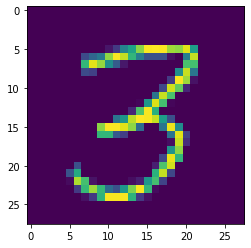

In [89]:
i=12
fn = df['fn'][i]

prev_img(fn)
point_from_img(fn)

##### Apply Function along all images, put in `df2`

In [102]:
vals = [point_from_img(e) for e in df['fn']]
vals

[(5, 11),
 (4, 9),
 (3, 12),
 (4, 13),
 (4, 5),
 (4, 13),
 (4, 14),
 (4, 13),
 (5, 10),
 (5, 15),
 (5, 6),
 (4, 16),
 (5, 10),
 (5, 10),
 (4, 17),
 (4, 14),
 (6, 8),
 (5, 8),
 (5, 6),
 (5, 11),
 (6, 6),
 (6, 7),
 (5, 9),
 (5, 12),
 (4, 15),
 (5, 8),
 (5, 12),
 (6, 10),
 (5, 10),
 (5, 13),
 (6, 11),
 (4, 14),
 (4, 15),
 (4, 9),
 (5, 10),
 (4, 11),
 (6, 9),
 (6, 13),
 (7, 12),
 (4, 7),
 (4, 11),
 (5, 9),
 (5, 3),
 (5, 11),
 (4, 11),
 (5, 10),
 (5, 11),
 (5, 9),
 (4, 11),
 (5, 12),
 (5, 10),
 (5, 12),
 (5, 8),
 (5, 11),
 (5, 6),
 (4, 12),
 (4, 9),
 (4, 13),
 (4, 10),
 (6, 13),
 (4, 8),
 (5, 9),
 (4, 8),
 (4, 13),
 (5, 6),
 (4, 10),
 (5, 14),
 (4, 15),
 (5, 9),
 (5, 5),
 (4, 9),
 (4, 11),
 (7, 15),
 (5, 11),
 (6, 9),
 (5, 6),
 (4, 15),
 (4, 15),
 (4, 21),
 (4, 7),
 (4, 19),
 (5, 8),
 (6, 19),
 (7, 17),
 (4, 7),
 (4, 8),
 (4, 12),
 (6, 6),
 (4, 18),
 (6, 11),
 (5, 11),
 (4, 10),
 (4, 9),
 (5, 6),
 (6, 4),
 (4, 12),
 (6, 9),
 (4, 7),
 (5, 11),
 (6, 7),
 (5, 10),
 (5, 7),
 (3, 9),
 (6, 10),
 

In [104]:
df_p = pd.DataFrame(vals, columns=['py','px'])

In [105]:
df2 = pd.concat((df,df_p ), axis=1)
df2

,index,fn,y,py,px
0,0,/train/3/7.png,3,5,11
1,1,/train/3/7030.png,3,4,9
2,2,/train/3/7031.png,3,3,12
3,3,/train/3/7043.png,3,4,13
4,4,/train/3/7046.png,3,4,5
...,...,...,...,...,...
704,358,/train/7/9955.png,7,7,17
705,359,/train/7/9988.png,7,7,5
706,360,/train/7/9990.png,7,7,9
707,361,/train/7/9992.png,7,8,3


##### ColReader Investigation

In [91]:
tmp_df = pd.DataFrame({'a':["5,10"], 'b':[5], 'c':[10]})
tmp_df

,a,b,c
0,"5,10",5,10


In [92]:
tmp_df.dtypes

a    object
b     int64
c     int64
dtype: object

In [95]:
cr = ColReader(['b','c'], )
ret = cr(tmp_df)
ret

(#2) [0    5
Name: b, dtype: int64,0    10
Name: c, dtype: int64]

In [99]:
ret[0], ret[1]

(0    5
 Name: b, dtype: int64,
 0    10
 Name: c, dtype: int64)

In [100]:
cr = ColReader('a', label_delim=',')
cr(tmp_df)

AttributeError: 'Series' object has no attribute 'split'

In [279]:
df2.dtypes

index     int64
fn       object
y        object
py        int64
px        int64
dtype: object

##### Pass info into a DataLoaders

In [164]:
mnist5 = DataBlock(blocks=(ImageBlock(cls=PILImageBW), PointBlock), 
                  splitter=RandomSplitter(),
                   get_x=ColReader('fn', pref=path),
                   get_y=ColReader(['px', 'py'])
                  )

In [165]:
mnist5_dls = mnist5.dataloaders(df2)

In [277]:
len(mnist5_dls.train.get_idxs())

568

In [278]:
b[1]

TensorPoint([[[ 0.0714, -0.5714]],

        [[-0.5714, -0.6429]],

        [[-0.3571, -0.5714]],

        [[-0.5000, -0.5000]],

        [[-0.4286, -0.4286]],

        [[ 0.2143, -0.5000]],

        [[ 0.2143, -0.5000]],

        [[-0.1429, -0.6429]],

        [[-0.2143, -0.5714]],

        [[-0.3571, -0.5000]],

        [[-0.3571, -0.6429]],

        [[-0.5714, -0.6429]],

        [[-0.0714, -0.5714]],

        [[-0.5714, -0.4286]],

        [[-0.7143, -0.6429]],

        [[-0.2857, -0.5714]],

        [[-0.4286, -0.5000]],

        [[-0.5714, -0.6429]],

        [[-0.3571, -0.6429]],

        [[ 0.1429, -0.6429]],

        [[-0.5000, -0.6429]],

        [[-0.1429, -0.6429]],

        [[ 0.1429, -0.5714]],

        [[-0.7143, -0.5714]],

        [[-0.2143, -0.5714]],

        [[-0.4286, -0.5000]],

        [[ 0.2143, -0.5714]],

        [[-0.7857, -0.6429]],

        [[-0.1429, -0.6429]],

        [[-0.7143, -0.5000]],

        [[-0.0714, -0.6429]],

        [[-0.2857, -0.7143]],

   

##### Batches info, types, encoded + decoded

In [203]:
b = mnist5_dls.one_batch()
b[1][:2]

tensor([[[ 0.0714, -0.5714]],

        [[-0.5714, -0.6429]]])

In [227]:
b2 = mnist5_dls.decode_batch(b, max_n=mnist5_dls.bs)
b2[0][1]

TensorPoint([[15.0000,  6.0000]])

In [228]:
type(b[0][0]), type(b2[0][0])

(torch.Tensor, fastai2.torch_core.TensorImageBW)

In [229]:
type(b[1][0]), type(b2[0][1])

(torch.Tensor, fastai2.vision.core.TensorPoint)

In [230]:
len(b[0]), len(b2)

(64, 64)

##### Graphical Displays

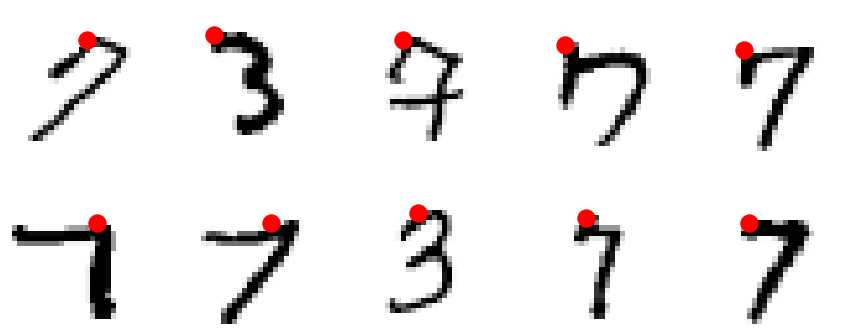

In [232]:
rows, cols = 2,5
fig, ax = plt.subplots(nrows=rows, ncols=cols, figsize=(3*cols,3*rows))
axr = ax.ravel()

for i in range(rows*cols):

    b2[i][0].show(ctx=axr[i])
    b2[i][1].show(ctx=axr[i], s=300, marker='o', c='red')


##### Model

In [260]:
learn5 = cnn_learner(mnist5_dls, resnet18, pretrained=False,metrics=[mse])
learn5.fit_one_cycle(8)

epoch,train_loss,valid_loss,mse,time
0,3.898243,0.231975,0.231975,00:10
1,3.612008,0.868372,0.868372,00:10
2,3.472190,16.810099,16.810099,00:09
3,3.249985,11.054986,11.054986,00:08
4,3.041879,0.773751,0.773751,00:09
5,2.802784,0.672220,0.672220,00:08
6,2.618718,0.359439,0.359439,00:08
7,2.470753,0.262462,0.262462,00:09


In [275]:
b[0][0].shape

torch.Size([1, 28, 28])

In [282]:
df2

,index,fn,y,py,px
0,0,/train/3/7.png,3,5,11
1,1,/train/3/7030.png,3,4,9
2,2,/train/3/7031.png,3,3,12
3,3,/train/3/7043.png,3,4,13
4,4,/train/3/7046.png,3,4,5
...,...,...,...,...,...
704,358,/train/7/9955.png,7,7,17
705,359,/train/7/9988.png,7,7,5
706,360,/train/7/9990.png,7,7,9
707,361,/train/7/9992.png,7,8,3


In [283]:
df2.dtypes

index     int64
fn       object
y        object
py        int64
px        int64
dtype: object

##### Evaluation

In [261]:
preds = learn5.get_preds(with_input=True, with_decoded=True, )

In [262]:
len(preds)

4

In [263]:
#predicted
preds[1][:3]

tensor([[ 9.6826e-02, -5.6078e-01],
        [-4.6307e-04,  5.6478e-02],
        [-1.0355e-01, -5.1902e-01]])

In [264]:
#actuals
preds[2][:3]

tensor([[[-0.2143, -0.7143]],

        [[-0.2857, -0.5000]],

        [[-0.7143, -0.4286]]])

In [265]:
preds[3][:3]

tensor([[ 9.6826e-02, -5.6078e-01],
        [-4.6307e-04,  5.6478e-02],
        [-1.0355e-01, -5.1902e-01]])

In [266]:
decode_batch = mnist5_dls.decode_batch(mnist5_dls.valid.one_batch(), max_n=10)

In [267]:
decode_preds = mnist5_dls.decode_batch((preds[0], preds[1]), max_n=10)

Text(0.5, 0.98, 'red:actual | green:predicted')

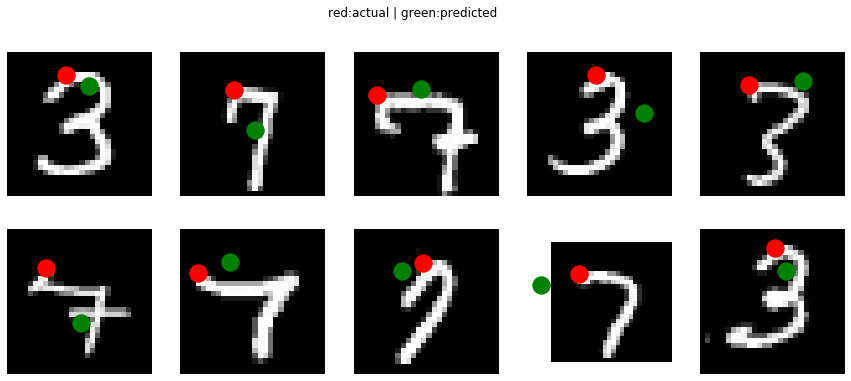

In [273]:
rows, cols = 2,5
fig, ax = plt.subplots(nrows=rows, ncols=cols, figsize=(3*cols,3*rows))
axr = ax.ravel()

for i in range(rows*cols):

    decode_batch[i][0].show(ctx=axr[i])
    decode_batch[i][1].show(ctx=axr[i], s=300, marker='o', c='red')
    decode_preds[i][1].show(ctx=axr[i], s=300, marker='o', c='green')

fig.suptitle('red:actual | green:predicted')

Hmmm, now it's black background with white text? Before it was opposite, is this causing the detremental imapct?

In [280]:
learn5.model

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  